In [1]:
from sheap.spectra_readers import parallel_reader 
from sheap.MainSheap import Sheapectral 
from sheap.RegionHandler.RegionBuilder import RegionBuilder
from sheap.RegionHandler.RegionFitting import RegionFitting
from sheap.Plotting.SheapPlot import SheapPlot
from sheap.Posterior.ParameterEstimation import ParameterEstimation


In [2]:
import jax 
from jax import jit 
import jax.numpy as jnp
import glob 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
from paths_func import cross_pandas_spectra
jax.config.update("jax_enable_x64", True)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path_dr16 = "/home/favila/smbh_mass/dr16"
#path_dr16 = "/home/felipe/work/SMBH_estimation/dr16"

In [44]:
#file_paths,objs_panda  = cross_pandas_spectra(path_dr16,"sdss_fits","dr16_pandas.csv")
#objs_panda_sort =objs_panda
file_paths,objs_panda = cross_pandas_spectra(path_dr16,"new_sub_sample_sdss_fits","subsample_07_03_25_full.csv")
objs_panda_sort = objs_panda.sort_values("SN_MEDIAN_ALL",ascending=False)[:1500][:100][:10]
objs_panda_sort = objs_panda_sort.reset_index(drop=True)

You cross match found 11538


In [45]:
coords,spectra_reshaped,_ = parallel_reader(objs_panda_sort.fit_path.values)
coords = jnp.array(coords)
spectra_reshaped = jnp.array(spectra_reshaped)

/home/favila/smbh_mass/sheap/sheap/spectra_readers.py:14: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (float(hdul[0].header["BUNIT"].split(" ")[0]) / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]*float(hdul[0].header["BUNIT"].split(" ")[0])) for key in ["loglam", "flux", "ivar"]])
/home/favila/smbh_mass/sheap/sheap/spectra_readers.py:14: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (float(hdul[0].header["BUNIT"].split(" ")[0]) / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]*float(hdul[0].header["BUNIT"].split(" ")[0])) for key in ["loglam", "flux", "ivar"]])
/home/favila/smbh_mass/sheap/sheap/spectra_readers.py:14: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (float(hdul[0].header["BUNIT"].split(" ")[0]) / np.sqrt(hdul[1].data[key]) i

In [46]:
# objs_panda_sort["LOGL5100"]

In [47]:
test_clase = Sheapectral(spectra_reshaped,z=objs_panda_sort["Z_DR16Q"].values,coords = coords)
z_s=test_clase.z
#norm_factor=10**test_clase.spectra_exp
exp_factor = test_clase.spectra_exp
Spectra = test_clase.spectra

In [83]:
region = RegionBuilder(4400, 5600)
region.make_region(verbose=True,Fe_regions=['Fe_uv',"FeII_IZw1","feII_forbidden","FeII_coronal"],force_linear=True
                   ,n_broad = 2,n_narrow =1,narrow_plus=False,add_out_flow=True,tied_narrow_to="OIIIc",template_mode_Fe=False)
Hbeta_class = RegionFitting(region.to_complex(add_free=True))

We assume a local linear continuum


In [ ]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class SpectralLine:
    center: float
    line_name: str
    kind: str
    component: int
    amplitude: float = 0.0            # default amplitude
    how: Optional[str] = None         # None if missing
    region: Optional[str] = None      # None if missing
    profile: Optional[str] = None     # None if missing
    how : Optional[str] = None 
    

In [105]:
Hbeta_class.dict_region["region"]

[{'center': 4418.957,
  'line_name': 'FeIIa',
  'kind': 'fe',
  'component': 20,
  'amplitude': 0.01,
  'how': 'sum',
  'region': 'Fe_uv',
  'profile': 'guassian'},
 {'center': 4449.616,
  'line_name': 'FeIIb',
  'kind': 'fe',
  'component': 20,
  'amplitude': 0.01,
  'how': 'sum',
  'region': 'Fe_uv',
  'profile': 'guassian'},
 {'center': 4471.273,
  'line_name': 'FeIIc',
  'kind': 'fe',
  'component': 20,
  'amplitude': 0.01,
  'how': 'sum',
  'region': 'Fe_uv',
  'profile': 'guassian'},
 {'center': 4493.529,
  'line_name': 'FeIId',
  'kind': 'fe',
  'component': 20,
  'amplitude': 0.01,
  'how': 'sum',
  'region': 'Fe_uv',
  'profile': 'guassian'},
 {'center': 4614.551,
  'line_name': 'FeIIe',
  'kind': 'fe',
  'component': 20,
  'amplitude': 0.01,
  'how': 'sum',
  'region': 'Fe_uv',
  'profile': 'guassian'},
 {'center': 4625.481,
  'line_name': 'FeIIf',
  'kind': 'fe',
  'component': 20,
  'amplitude': 0.01,
  'how': 'sum',
  'region': 'Fe_uv',
  'profile': 'guassian'},
 {'center'

In [92]:
SpectralLine(**Hbeta_class.dict_region["region"][0])

SpectralLine(center=4418.957, line_name='FeIIa', kind='fe', component=20, amplitude=0.01, how='sum', region='Fe_uv', profile='guassian')

In [95]:
lines = [SpectralLine(**i) for i in Hbeta_class.dict_region["region"]]

- template with 1000 as initial it is ok 
- gaussian sum?

In [84]:
#Hbeta_class = RegionFitting("Halpha")
Hbeta_class(Spectra,exp_factor=exp_factor,num_steps=1000,re_normalize=True)

Runing: tied_params_step_1
learning_rate: 0.1
optimizer: adabelief
num_steps: 1000


Runing: tied_params_step_2
We assume a local linear continuum
learning_rate: 0.01
optimizer: adabelief
num_steps: 2000


In [ ]:
index_fe_lines,fe_lines = map(list,zip(*((i, line) for i, line in enumerate(lines) if line.kind == 'fe')))

In [104]:
index_fe_lines

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101]

In [66]:
Hbeta_class.panda_params[[i for i in Hbeta_class.panda_params.columns if "fe" in i and "width" in i]]

,width_FeIIa_20_fe,width_FeIIb_20_fe,width_FeIIc_20_fe,width_FeIId_20_fe,width_FeIIe_20_fe,width_FeIIf_20_fe,width_FeIIg_20_fe,width_FeIIh_20_fe,width_FeIIi_20_fe,width_FeIIj_20_fe,...,width_FeII18Fd_20_fe,width_FeII18Fe_20_fe,width_FeII18Ff_20_fe,width_FeII18Fg_20_fe,width_FeII18Fh_20_fe,width_FeII17Fa_20_fe,width_FeII17Fb_20_fe,width_FeII17Fc_20_fe,width_FeII34Fa_20_fe,width_FeII34Fb_20_fe
0,3.378599,3.240151,3.138953,17.850237,6.743876,3.558508,3.242393,3.244556,3.456948,3.273175,...,4.414855,4.937462,4.259413,3.805824,3.906862,3.861449,3.849737,3.920358,3.836721,3.891514
1,3.153832,3.182807,3.162512,40.389731,12.513842,3.578382,3.260177,3.244556,4.943834,3.270509,...,5.435693,5.899662,4.213782,4.382478,4.193401,3.986019,4.012589,4.605696,3.838856,3.989649
2,3.163267,3.358936,3.132058,15.519950,6.799409,3.505580,3.242393,3.264627,3.670044,3.270509,...,4.661940,5.063390,4.783421,3.805824,4.045203,3.797874,3.849737,3.977557,3.836721,3.890049
3,3.095411,3.116887,3.132058,8.003136,5.483591,3.277258,3.242393,3.269616,3.264674,3.270509,...,3.690762,4.393677,4.056283,3.842075,5.269103,3.969880,4.113069,4.471132,4.069554,3.932088
4,3.095411,3.116887,3.132058,3.420701,4.369028,3.281196,3.261788,3.270607,3.264674,3.270509,...,3.690762,4.065363,3.745946,5.213343,7.137341,3.791478,5.562743,3.871817,4.919054,3.872006
5,3.095411,3.255375,3.132058,7.663938,3.760468,3.467276,3.243261,3.244556,3.264674,3.270509,...,3.690762,3.693902,4.066441,4.954115,5.448294,4.163187,4.952909,5.602679,5.092294,3.872006
6,3.095411,3.296397,3.132058,9.927211,6.153810,3.387416,3.243692,3.399278,3.264674,3.270509,...,3.690762,3.693916,3.937602,3.805824,4.983644,3.791478,3.849737,3.871817,3.836721,3.872006
7,3.137366,3.516058,3.132060,6.301903,5.297021,3.240078,3.252665,3.588359,3.547912,3.270985,...,3.904995,4.941786,3.903693,3.899800,3.892096,4.001558,3.858396,4.316588,3.836721,3.872043
8,3.095411,3.116887,3.132058,25.959811,5.361787,3.263281,3.242393,3.267418,3.530935,3.280801,...,3.690762,4.116671,4.031326,3.846737,4.043976,3.795110,3.849737,3.902737,3.836721,3.968295
9,3.280026,3.116887,3.132058,38.335156,5.934570,3.694146,3.353617,3.582873,3.264674,4.258823,...,5.621370,5.529566,4.199239,4.236498,4.072223,4.435969,4.596169,4.971410,3.854262,4.091715


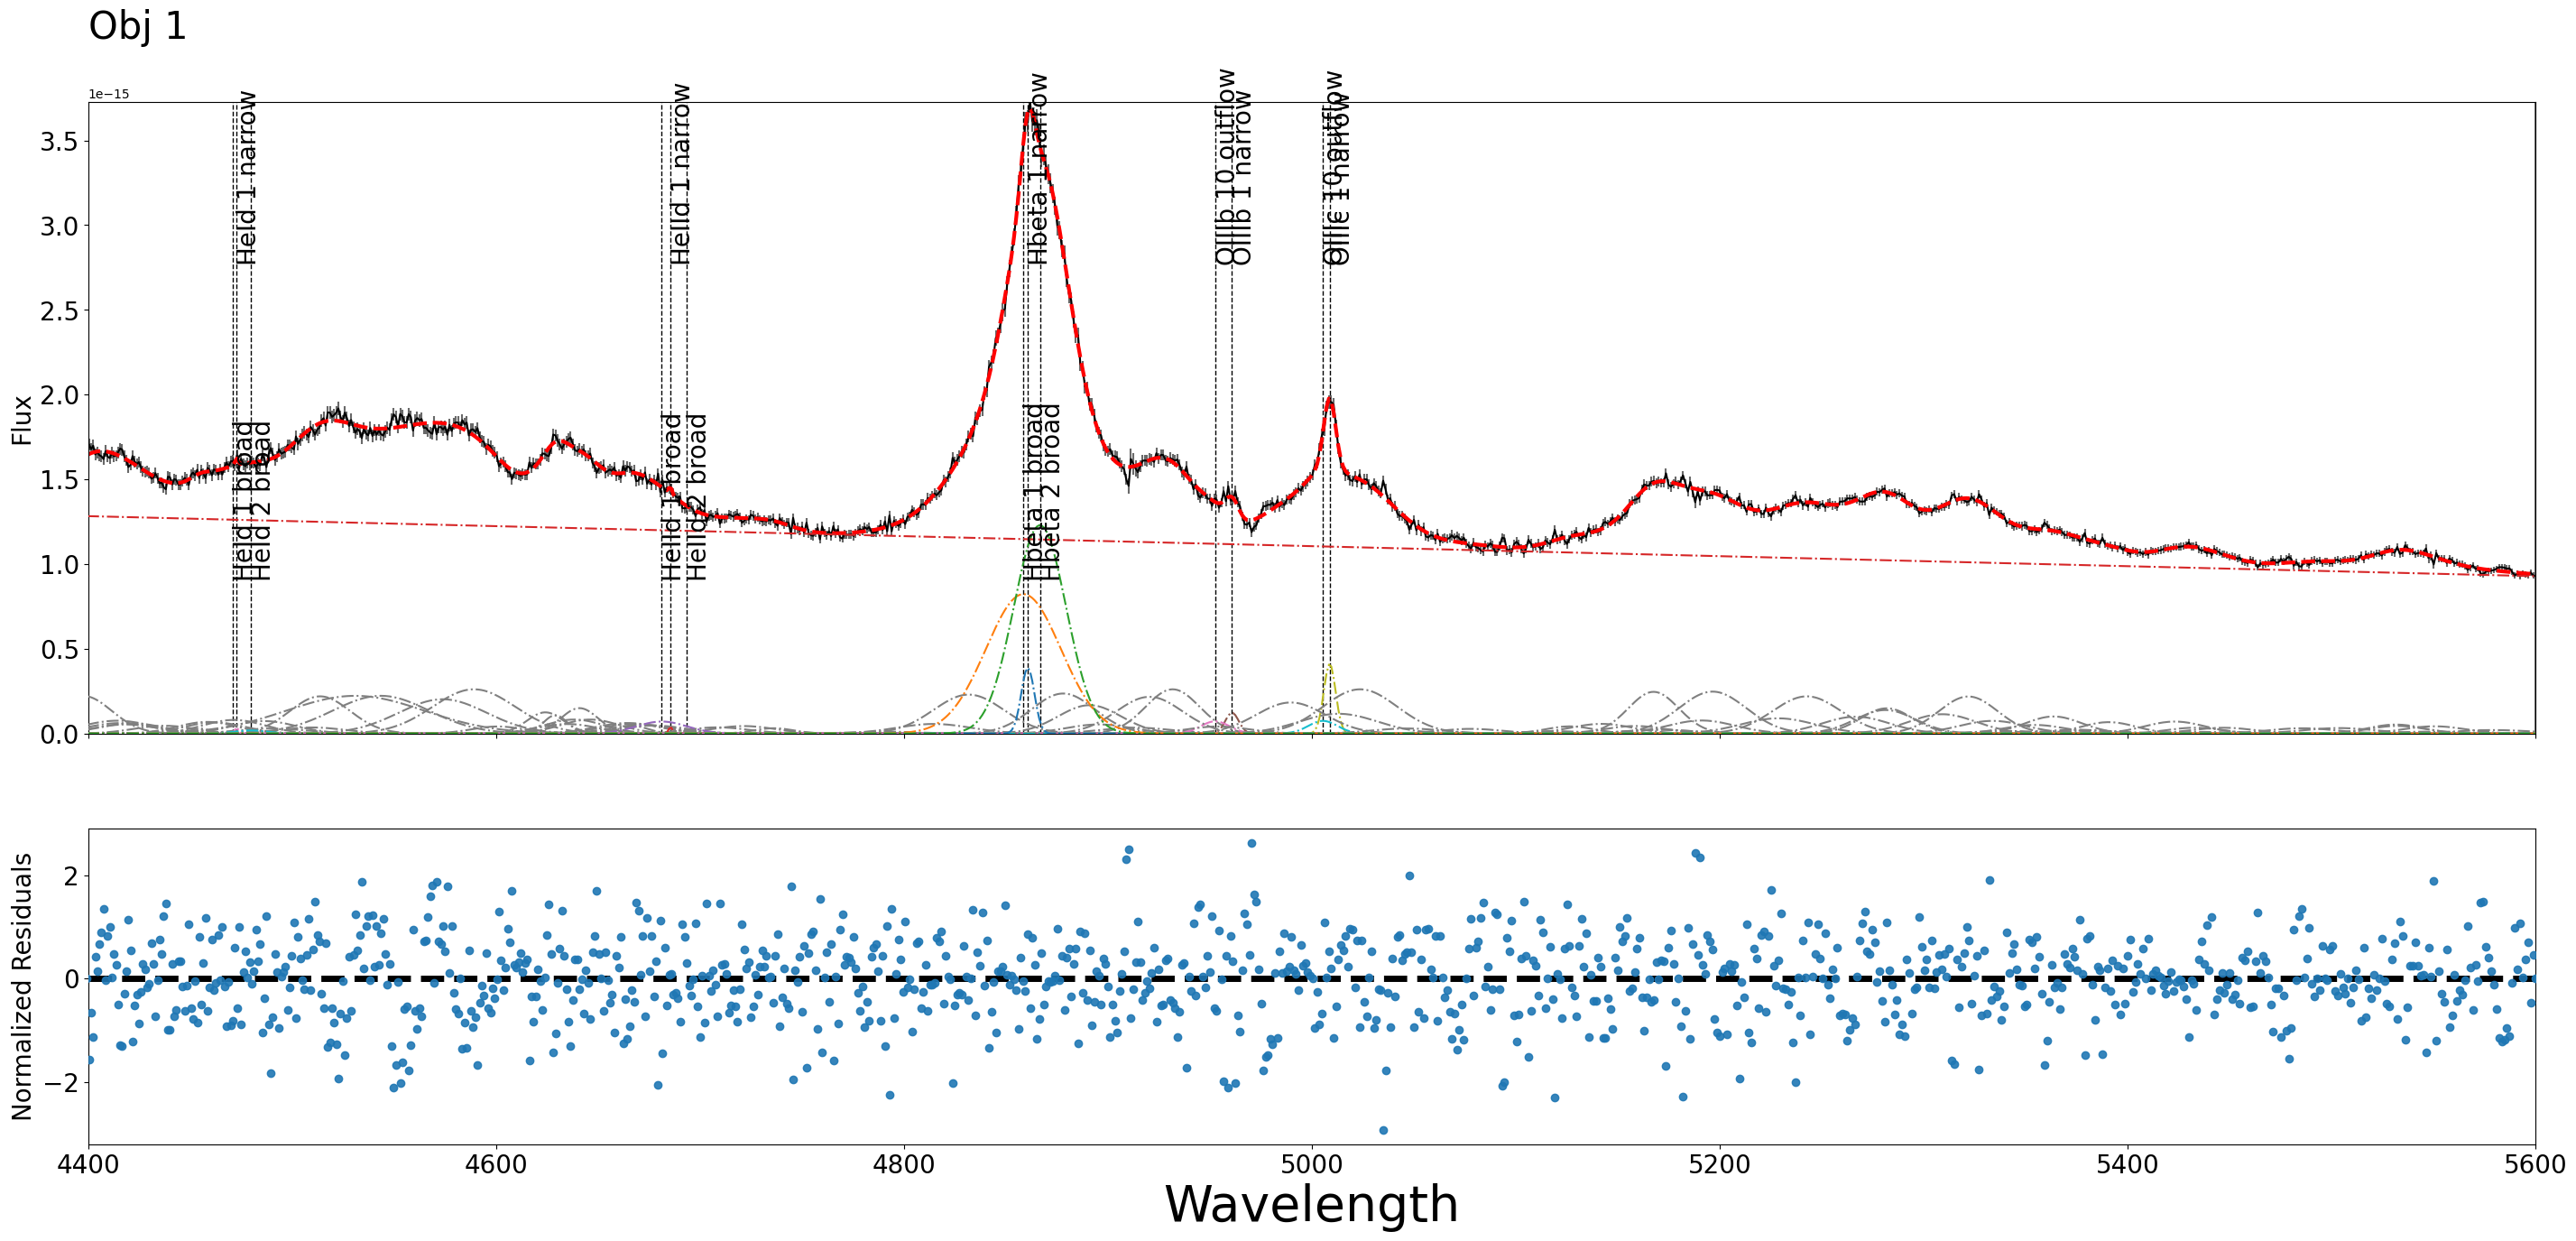

In [85]:
n = 1
region_plot = SheapPlot(Hbeta_class)
region_plot.plot(n,xlim=[4400, 5600],add_name=True)#207

In [61]:
params = ParameterEstimation(Hbeta_class, z=test_clase.z)

In [55]:
test_clase.z

Array([0.185441  , 0.1358    , 0.141583  , 0.143862  , 0.12240168,
       0.165     , 0.17651476, 0.122     , 0.18202062, 0.139838  ,
       0.1743    , 0.15414871, 0.16176946, 0.15369116, 0.154338  ,
       0.18603608, 0.15976128, 0.12372507, 0.154     , 0.153555  ,
       0.17400485, 0.12178772, 0.17900679, 0.125022  , 0.13477451,
       0.12855373, 0.20605712, 0.1761    , 0.17705989, 0.17808317,
       0.130988  , 0.17068055, 0.17189249, 0.1676    , 0.16258939,
       0.1221311 , 0.1222    , 0.17655264, 0.168756  , 0.153207  ,
       0.119     , 0.16424249, 0.1301    , 0.143     , 0.136654  ,
       0.1559    , 0.1074    , 0.144271  , 0.13077047, 0.189     ,
       0.15108377, 0.1485    , 0.122064  , 0.118     , 0.18852302,
       0.11625048, 0.166     , 0.17470494, 0.132     , 0.18436816,
       0.14591722, 0.261015  , 0.1446    , 0.18424456, 0.14      ,
       0.22067973, 0.126354  , 0.125527  , 0.11181036, 0.12473958,
       0.19292678, 0.22095601, 0.11363225, 0.1775    , 0.25775

In [ ]:
0.185441

In [39]:
objs_panda_sort.LOGL5100.values - jnp.log10(params.L5100()*3000).ravel()

Array([0.17445301, 0.16762678, 0.18130131, 0.20642279, 0.21113114,
       0.25692381, 0.19069251, 0.21140591, 0.176923  , 0.18194951,
       0.21645057, 0.20475489, 0.19507591, 0.22123285, 0.20286551,
       0.19133499, 0.2062028 , 0.20424251, 0.19105231, 0.1655424 ,
       0.19631822, 0.19806463, 0.21115481, 0.19161375, 0.20447625,
       0.21221514, 0.21118824, 0.21694864, 0.19801218, 0.22123285,
       0.19013348, 0.20441782, 0.17803737, 0.21593779, 0.19429378,
       0.20870372, 0.1955212 , 0.2183039 , 0.16992992, 0.19457422,
       0.21642261, 0.2094575 , 0.21453313, 0.19615212, 0.17616223,
       0.22245844, 0.23020025, 0.19360359, 0.18720566, 0.22130398,
       0.16678881, 0.19672433, 0.19134998, 0.1971968 , 0.19926642,
       0.2221238 , 0.18227   , 0.20186187, 0.18591685, 0.21135117,
       0.19489374, 0.22815677, 0.21435772, 0.21532669, 0.26167029,
       0.21659986, 0.19502293, 0.2176943 , 0.22029669, 0.25488827,
       0.19301594, 0.21050852, 0.21153089, 0.19095087, 0.18326

In [48]:
from jax import vmap
ff = vmap(params.RegionClass.profile_function_list[-1],in_axes=(None, 0))
#plt.plot(params.,params.baselines[0])
xx = ff(jnp.array(5100),params.values)

(4400.0, 5600.0)

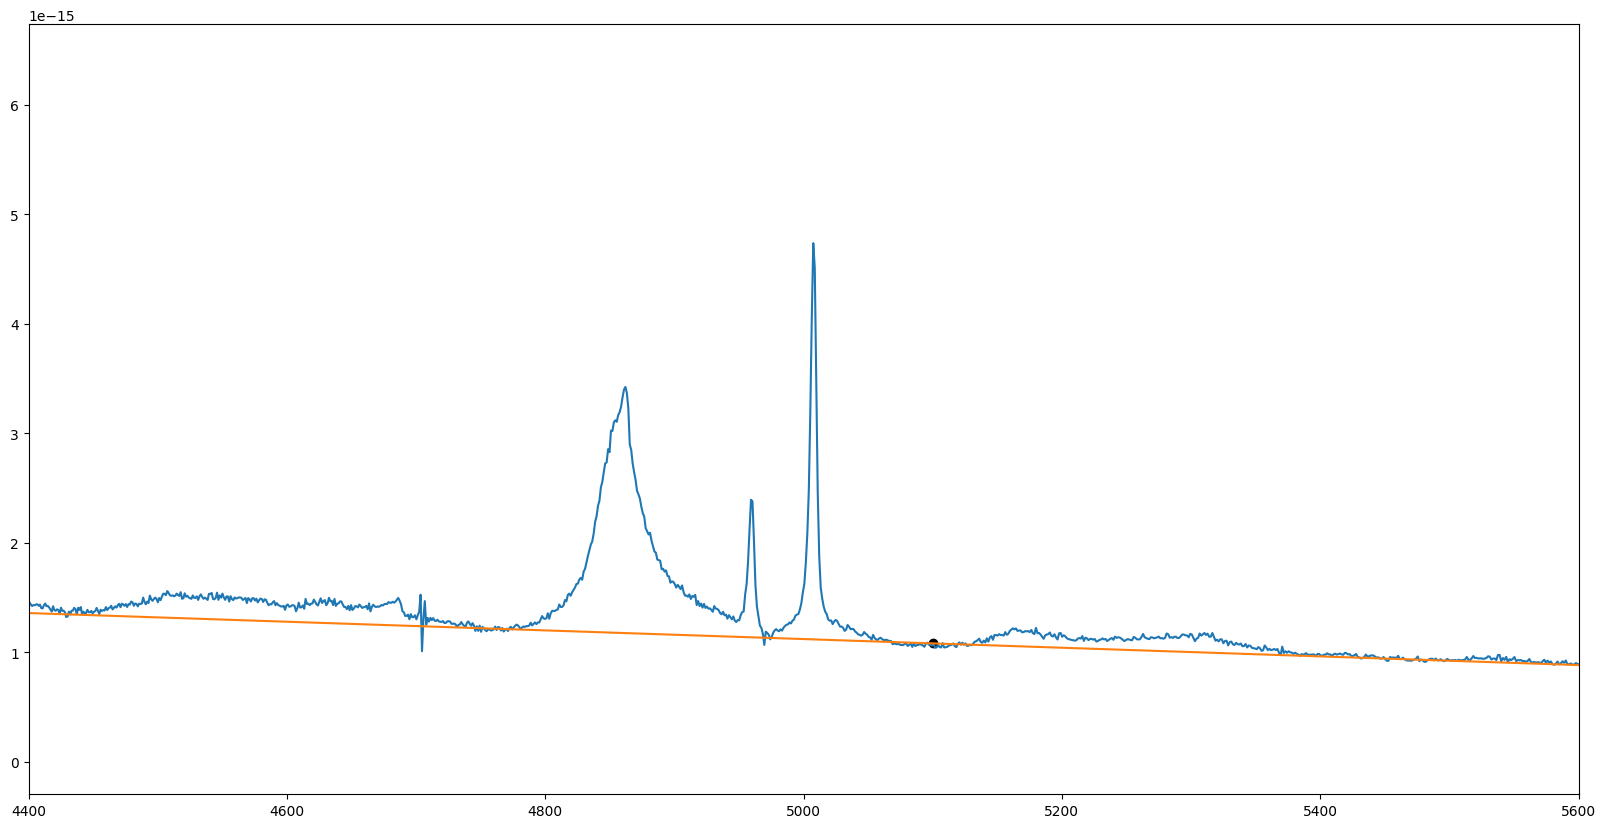

In [51]:
plt.figure(figsize=(20,10))
plt.plot(params.RegionClass.region_to_fit[0,0,:],params.RegionClass.region_to_fit[0,1,:])
plt.plot(params.RegionClass.region_to_fit[0,0,:],params.baselines[0])
plt.scatter(5100,xx[0],c="k")
plt.xlim(4400, 5600)

In [60]:
params.panda_luminosity

,FeIIa_20_fe,FeIIb_20_fe,FeIIc_20_fe,FeIId_20_fe,FeIIe_20_fe,FeIIf_20_fe,FeIIg_20_fe,FeIIh_20_fe,FeIIi_20_fe,FeIIj_20_fe,...,FeII34Fb_20_fe,HeIId_1_narrow,HeIId_1_broad,HeIId_2_broad,HeId_1_narrow,HeId_1_broad,HeId_2_broad,Hbeta_1_narrow,Hbeta_1_broad,Hbeta_2_broad
0,1.351782e+40,4.168976e+39,1.379501e+39,1.873041e+41,9.992392e+40,8.505729e+40,7.430141e+40,7.172598e+40,4.052174e+40,6.667485e+39,...,9.711269e+39,2.274347e+40,3.654067e+41,1.681525e+41,4.866502e+39,1.009515e+41,1.021236e+41,2.150142e+41,4.075412e+42,1.329070e+42
1,5.282254e+40,2.956423e+40,1.053427e+40,8.100733e+40,8.062603e+40,1.147938e+41,8.949253e+40,7.400741e+40,3.833389e+40,9.777380e+39,...,5.589086e+40,1.998621e+39,3.375872e+41,1.288818e+40,2.600682e+39,2.934362e+41,1.118781e+41,0.000000e+00,1.808475e+42,1.367965e+42
2,7.205809e+40,4.190044e+40,4.098561e+40,2.705829e+41,1.717043e+41,1.185702e+41,7.727084e+40,8.023897e+40,4.217667e+40,1.924109e+40,...,0.000000e+00,8.867119e+39,2.415831e+41,3.694551e+41,9.425079e+39,4.597903e+41,2.949717e+41,2.530143e+41,3.374937e+42,2.321221e+42
3,6.651715e+40,5.009460e+40,5.816507e+39,1.913009e+41,1.843659e+41,1.756035e+41,8.940399e+40,7.476848e+40,6.403173e+40,3.472478e+40,...,0.000000e+00,2.917644e+40,2.858831e+41,5.338936e+41,7.716934e+39,3.427187e+41,3.046975e+41,1.341399e+41,1.756799e+42,1.847081e+42
4,6.956734e+39,3.618812e+39,2.496480e+39,5.074187e+39,1.256549e+40,1.188936e+40,1.895168e+40,1.684637e+40,4.601647e+39,0.000000e+00,...,0.000000e+00,5.912839e+39,5.708554e+40,9.442058e+39,1.838403e+39,0.000000e+00,2.216555e+40,9.144989e+39,2.029937e+41,1.422387e+41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.407894e+40,1.687947e+40,2.685293e+40,1.444124e+41,6.055354e+40,2.886703e+40,3.533561e+40,4.341508e+40,3.326643e+40,1.422509e+40,...,0.000000e+00,1.315630e+40,1.285601e+41,0.000000e+00,0.000000e+00,1.384743e+41,1.536872e+41,1.625397e+41,2.235988e+41,2.277721e+41
96,2.116464e+40,1.467399e+40,1.680533e+40,4.750950e+40,7.208497e+40,7.548147e+40,4.720020e+40,1.751270e+40,1.848387e+40,0.000000e+00,...,4.156619e+39,7.535730e+39,1.671222e+41,6.949576e+40,4.779656e+39,1.327768e+41,4.508281e+40,5.913804e+40,6.324392e+41,4.780728e+41
97,2.440645e+40,1.250656e+40,0.000000e+00,3.006597e+40,3.822793e+40,4.052168e+40,3.539873e+40,3.205026e+40,2.190524e+40,1.142653e+40,...,1.298531e+40,5.348316e+39,1.027485e+41,3.181843e+40,1.541872e+39,9.655035e+40,6.303161e+40,1.039190e+41,4.154374e+41,2.462160e+41
98,2.863844e+39,2.534742e+39,1.261810e+39,6.416902e+39,5.964301e+39,4.576404e+39,3.069770e+39,3.888275e+39,3.511152e+39,0.000000e+00,...,3.265429e+39,2.078448e+39,1.219982e+40,1.167932e+40,9.312387e+38,0.000000e+00,0.000000e+00,2.122071e+40,4.898898e+40,4.161837e+40


In [59]:
ff(jnp.array(5100),params.values)

Array([1.08159028e-15, 1.10124230e-15, 1.91861268e-15, 1.98600784e-15,
       3.81689392e-16, 4.33928927e-16, 5.49405380e-16, 6.20683536e-16,
       4.87500290e-16, 7.88000756e-16, 1.59763768e-15, 4.13768472e-16,
       6.61634396e-16, 3.22285501e-16, 1.30256298e-15, 4.99335981e-16,
       5.01410826e-16, 6.00833097e-16, 4.41469393e-16, 1.41637062e-15,
       3.34687777e-16, 3.18395068e-16, 4.69335080e-16, 1.05773252e-15,
       5.73868651e-16, 3.22323206e-16, 4.43421133e-16, 6.11721301e-16,
       4.13618558e-16, 3.94013101e-16, 1.38677904e-15, 2.78022647e-16,
       3.06080855e-16, 4.99768630e-16, 4.88031686e-16, 3.59874584e-16,
       2.13611355e-16, 3.11875180e-16, 3.98022774e-16, 3.42754234e-16,
       3.42300201e-16, 2.32191448e-16, 6.72045068e-16, 2.95137175e-16,
       7.34250649e-16, 5.29828710e-16, 6.53346636e-16, 5.75761173e-16,
       4.31416980e-16, 3.15406885e-16, 3.45081806e-16, 6.82101762e-16,
       4.19794880e-16, 2.24728362e-16, 2.49379181e-16, 2.15631752e-16,
      

In [29]:
# from typing import Any, Tuple, Mapping

# def dict_to_key(d: Mapping[Any, Any]) -> Tuple[Tuple[Any,Any], ...]:
#     """Convert a dict into a hashable, sorted tuple-of-items."""
#     return tuple(sorted(d.items()))

# def key_to_dict(key: Tuple[Tuple[Any,Any], ...]) -> dict:
#     """Convert back the tuple-of-items into a dict."""
#     return dict(key)

In [66]:
params.L5100()

Array([5.35735228e+44, 2.75157889e+44, 5.24927885e+44, 5.62617964e+44,
       7.61540242e+43, 1.66011492e+44, 2.43940890e+44, 1.22962050e+44,
       2.31695860e+44, 2.09849100e+44, 6.89828449e+44, 1.36324041e+44,
       2.42348481e+44, 1.05493721e+44, 4.30310482e+44, 2.49098363e+44,
       1.78686304e+44, 1.22694041e+44, 1.45143293e+44, 4.62721128e+44,
       1.43971171e+44, 6.28397777e+43, 2.14958433e+44, 2.20918912e+44,
       1.41045449e+44, 7.15033204e+43, 2.77834154e+44, 2.70199594e+44,
       1.84907876e+44, 1.78404798e+44, 3.20402092e+44, 1.14606788e+44,
       1.28159651e+44, 1.97901675e+44, 1.80758797e+44, 7.14593334e+43,
       4.24679091e+43, 1.38541128e+44, 1.60018854e+44, 1.11420836e+44,
       6.42664915e+43, 8.79357981e+43, 1.52996866e+44, 8.25209051e+43,
       1.85977909e+44, 1.78940057e+44, 9.84019361e+43, 1.64121275e+44,
       9.93162616e+43, 1.62969942e+44, 1.08801343e+44, 2.07097535e+44,
       8.32587103e+43, 4.14321940e+43, 1.28131546e+44, 3.84966987e+43,
      

In [348]:
params.Lbool()

(100,)


Array([ 6.07099778e+43,  0.00000000e+00,  6.42184572e+43,  9.52644722e+43,
        1.10447231e+44,  1.02933713e+43,  1.57411883e+44,  3.86354966e+43,
        1.13610289e+44,  1.17985777e+44,  6.92692592e+43,  9.54087233e+43,
        5.68900097e+43,  2.74696523e+43,  1.53490811e+43,  4.65729008e+43,
        8.79871747e+43,  6.04738337e+43,  3.11433962e+43,  1.02316808e+44,
        1.53146356e+43,  8.04551157e+43,  8.48744603e+43,  1.48774872e+43,
        6.69058632e+43,  2.83301139e+43,  1.26257919e+43,  6.27804388e+43,
        7.82843485e+43,  5.17596186e+43,  0.00000000e+00,  7.97816562e+43,
        6.02291787e+43, -6.46427181e+42,  0.00000000e+00,  5.01484193e+43,
        8.38923286e+42,  4.28895612e+43,  0.00000000e+00,  6.02989057e+43,
        1.21030364e+43,  3.46276299e+43,  4.10099604e+43,  2.93762753e+43,
        2.50140148e+43,  0.00000000e+00,  0.00000000e+00,  1.65182104e+43,
        6.20732171e+43,  2.81788558e+43,  1.17295831e+44,  7.25470604e+43,
        5.01984162e+43,  

In [ ]:
from jax.scipy.integrate import trapezoid
baselines_s = jnp.where(params.RegionClass.mask_region,0,params.baselines)
x = jnp.where(params.RegionClass.mask_region,0,params.RegionClass.region_to_fit[:,0,:])
flux = trapezoid(baselines_s, x=x, axis=1)
#flux = jsp.integrate.trapezoid(jnp.where(mask_fit_g,0,1-(full_model)/Baselines),x=jnp.where(mask_fit_g,0,Spectra[:,0,:]),axis=1)
#return 4. * jnp.pi * self.d**2 * flux 

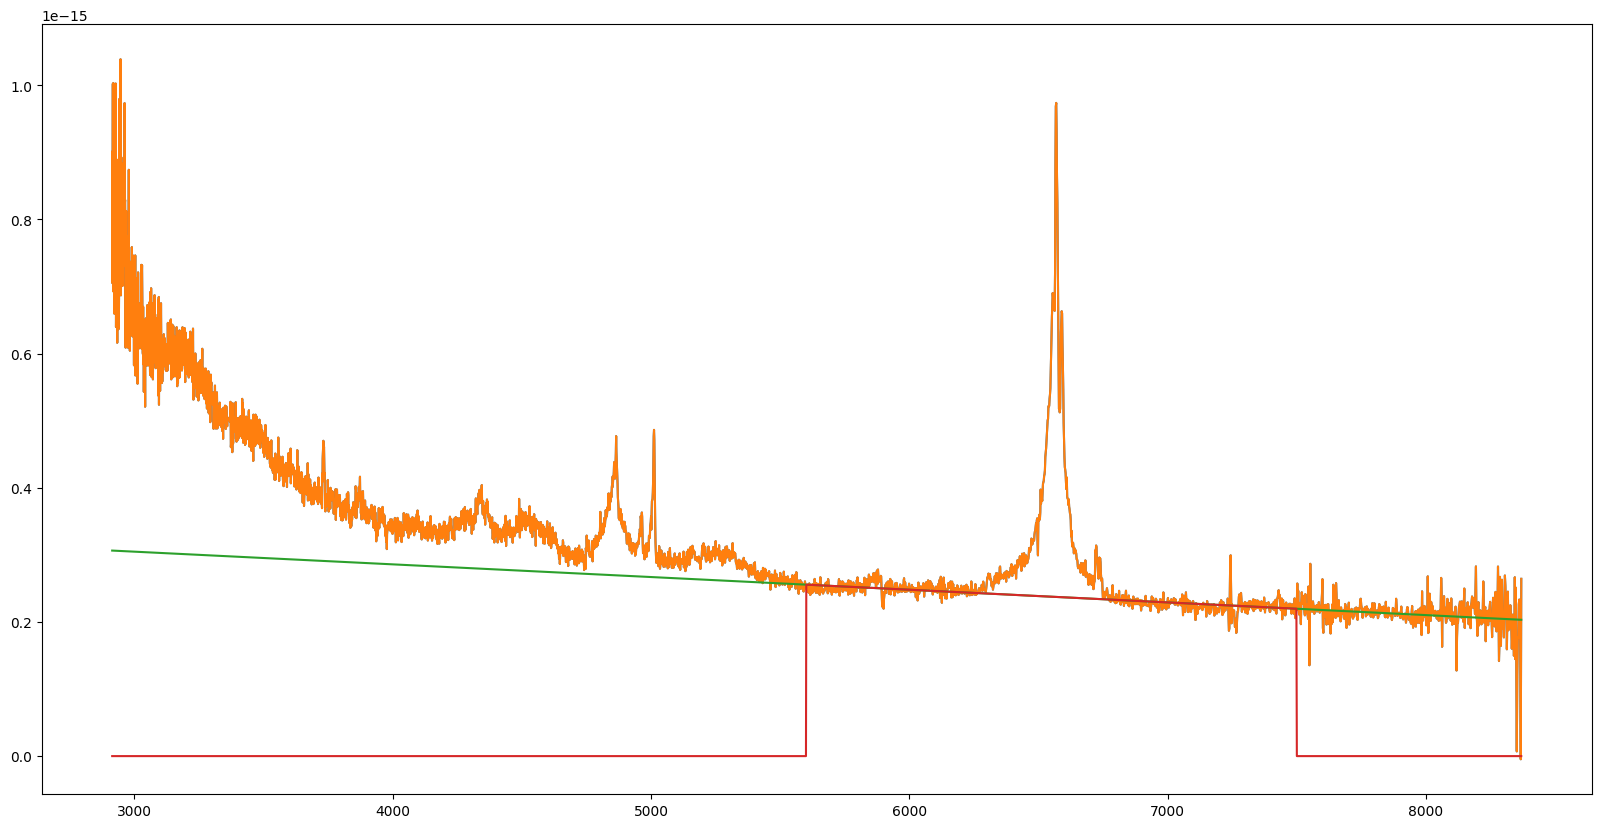

In [382]:
plt.figure(figsize=(20,10))
plt.plot(test_clase.spectra[0,0,:],test_clase.spectra[0,1,:]*10**(-exp_factor[0]))
plt.plot(params.RegionClass.region_to_fit[0,0,:],params.RegionClass.region_to_fit[0,1,:])
plt.plot(params.RegionClass.region_to_fit[0,0,:],params.baselines[0])
plt.plot(params.RegionClass.region_to_fit[0,0,:],baselines_s[0])


In [387]:
 4. * jnp.pi *flux[0]* params.d[0]**2

Array(6.07099778e+43, dtype=float64)

In [170]:
from jax import vmap 
from sheap.tools.others import vmap_get_EQW_mask
profile_index_list = Hbeta_class.profile_index_list
x_axis = Hbeta_class.region_to_fit[:,0,:]
mask = Hbeta_class.mask_region
#this is based on the idea about the continium is the last profile added to the code maybe could be a good idea have the exacto position of it 
min_,max_ = profile_index_list[-1]
values = Hbeta_class.params[:,min_:max_]
profile_func = vmap(Hbeta_class.profile_function_list[-1],in_axes=(0, 0))
baselines = profile_func(Hbeta_class.region_to_fit[:,0,:],values)
EW = []
for i,profile in enumerate(Hbeta_class.profile_list):
    profile_func = vmap(Hbeta_class.profile_function_list[i],in_axes=(0, 0))#maybe ask is the previous one is other proflie?
    min_,max_ = profile_index_list[i]
    values = Hbeta_class.params[:,min_:max_]
    if profile != "linear" and "Fe" not in profile:
        #we filter after the fe      
        emission_line = profile_func(x_axis,values) 
        c = jnp.stack([x_axis, emission_line], axis=1)
        ew = vmap_get_EQW_mask(c,baselines,mask)
        EW.append(ew)
    else:
        pass 
EW = jnp.stack(EW, axis=1)

In [171]:
pd.DataFrame(EW,columns=Hbeta_class.lines_list)

,HeIe_1_narrow,HeIe_1_broad,HeIe_2_broad,HeIf_1_narrow,HeIf_1_broad,HeIf_2_broad,HeIg_1_narrow,HeIg_1_broad,HeIg_2_broad,NaIa_1_broad,...,OIa_1_narrow,OIb_1_narrow,SIIa_1_narrow,SIIb_1_narrow,OIIc_1_narrow,NIIa_1_narrow,NIIb_1_narrow,FeII34Fc_20_fe,FeII14Fa_20_fe,FeII14Fb_20_fe
0,1438.602897,1438.910612,1437.129591,1438.800170,1438.910612,1438.910612,1438.729252,1438.910612,1438.910612,1438.910612,...,1437.825313,1438.910612,1436.213843,1436.813382,1438.862436,1432.128223,1437.291058,1438.905356,1438.910612,1438.910612
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1406.717433,1402.042226,1407.389616,1407.260098,1407.389616,1407.389616,1407.389616,1407.389616,1406.280295,1407.389616,...,1406.969085,1406.590351,1405.650218,1405.933604,1407.294049,1403.114274,1405.134442,1407.118864,1407.389616,1407.389616
3,274.731213,273.906945,273.906945,274.983622,274.983622,274.983622,274.983622,274.983622,274.983622,273.952923,...,274.983622,274.983622,274.983622,274.983622,274.983622,274.983622,274.983622,273.993298,274.983622,274.983622
4,1295.858490,1295.858490,1293.090302,1295.858490,1295.858490,1295.858490,1295.858490,1292.861555,1295.858490,1295.858490,...,1294.926254,1294.684297,1295.418025,1295.565291,1295.154390,1288.380041,1293.614902,1295.858490,1295.858490,1295.858490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,895.346137,896.113084,886.588132,896.113084,896.113084,895.671833,896.113084,896.113084,896.113078,896.113084,...,894.017714,895.846109,895.176233,895.303120,896.113084,894.671586,895.728678,895.187890,896.113084,896.113084
96,456.469202,455.571013,455.571013,457.997529,457.997529,457.997529,457.997529,457.997529,457.997529,456.186538,...,456.972795,457.997529,457.997529,457.997529,457.997529,457.997529,457.997529,457.028394,457.997529,457.997529
97,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,...,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,81.780629,101.266082,101.266082
98,1292.982619,1292.249011,1291.951057,1293.007980,1293.281023,1293.281023,1293.145895,1293.281023,1293.281023,1293.281023,...,1292.983296,1293.147427,1292.627412,1292.559576,1292.160910,1289.845303,1292.031043,1292.868672,1293.281023,1293.235579


In [165]:
len(Hbeta_class.lines_list)

47

In [166]:
profile

'linear'

In [145]:
x_axis.shape

(100, 4638)

In [ ]:
#def ew_line():

In [73]:
params.continium_params_values

Array([[-1.89117583e-17,  3.61497295e-16],
       [            nan,             nan],
       [-2.38806966e-17,  3.51558949e-16],
       [-1.70854087e-17,  4.22844590e-16],
       [-1.86996220e-17,  2.56126873e-16],
       [ 6.35251784e-18,  1.60950187e-16],
       [-3.43635947e-17,  3.51082469e-16],
       [-1.77059230e-18,  1.70531108e-16],
       [-1.56044673e-17,  2.07665412e-16],
       [-1.82712658e-17,  2.37769917e-16],
       [-9.98148190e-18,  2.52742181e-16],
       [-3.05413856e-17,  3.96427870e-16],
       [-4.07173400e-17,  5.46615786e-16],
       [-1.14349770e-17,  2.33568892e-16],
       [-1.90162139e-17,  2.73253118e-16],
       [-1.27470335e-17,  1.71338867e-16],
       [-1.06031971e-17,  1.44915151e-16],
       [ 4.34521716e-18,  2.14808030e-16],
       [-2.49669927e-18,  8.79052730e-17],
       [-1.58948471e-17,  1.90217696e-16],
       [ 6.93178810e-18,  2.71623022e-17],
       [-1.46373684e-17,  1.94820258e-16],
       [-1.50793950e-17,  1.70113794e-16],
       [ 8.

In [71]:
params.params_cont

array(['m_cont', 'b_cont'], dtype='<U25')

In [ ]:
Hbeta_class.profile_list[-1]

['guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'linear']

In [13]:
params.panda_flux

,HeIe_1_narrow,HeIe_1_broad,HeIe_2_broad,HeIf_1_narrow,HeIf_1_broad,HeIf_2_broad,HeIg_1_narrow,HeIg_1_broad,HeIg_2_broad,NaIa_1_broad,...,OIa_1_narrow,OIb_1_narrow,SIIa_1_narrow,SIIb_1_narrow,OIIc_1_narrow,NIIa_1_narrow,NIIb_1_narrow,FeII34Fc_20_fe,FeII14Fa_20_fe,FeII14Fb_20_fe
0,8.766991e-17,0.000000e+00,5.056826e-16,3.779408e-17,0.000000e+00,0.000000e+00,6.393857e-17,0.000000e+00,0.000000e+00,0.000000e+00,...,3.312777e-16,0.000000e+00,8.774270e-16,6.838921e-16,1.710937e-17,2.163091e-15,5.137665e-16,1.461596e-18,0.000000e+00,0.000000e+00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.605306e-16,1.273991e-15,0.000000e+00,3.720356e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.303822e-16,0.000000e+00,...,1.076751e-16,2.067265e-16,4.749166e-16,3.983435e-16,2.848616e-17,1.144274e-15,6.003018e-16,6.318282e-17,0.000000e+00,0.000000e+00
3,1.241640e-16,5.272512e-16,5.272512e-16,5.085935e-15,1.159844e-14,5.799222e-15,5.085935e-15,1.195329e-14,5.976644e-15,5.079428e-16,...,4.867188e-15,4.916241e-15,5.085935e-15,5.085935e-15,5.085935e-15,5.085935e-15,1.517574e-15,4.758731e-16,5.803971e-16,5.817631e-16
4,0.000000e+00,0.000000e+00,4.926378e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.662139e-16,0.000000e+00,0.000000e+00,...,1.777733e-16,2.258509e-16,8.956230e-17,5.974195e-17,1.930148e-16,1.490122e-15,4.446321e-16,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.083571e-17,0.000000e+00,1.125686e-15,1.893064e-15,7.418065e-15,1.417350e-14,1.893064e-15,7.418065e-15,2.739357e-14,0.000000e+00,...,5.918064e-16,3.425271e-17,1.268316e-16,1.099474e-16,1.893064e-15,1.913110e-16,5.073553e-17,1.073589e-16,3.581650e-16,3.590080e-16
96,1.181961e-16,1.947801e-16,1.947801e-16,1.998544e-15,4.557668e-15,2.278834e-15,1.998544e-15,4.697106e-15,2.348553e-15,1.403833e-16,...,8.507939e-17,0.000000e+00,1.998544e-15,1.998544e-15,1.998544e-15,1.998544e-15,5.963384e-16,7.341765e-17,2.280700e-16,2.286068e-16
97,3.893790e-15,9.239480e-15,4.619740e-15,4.361665e-15,9.946751e-15,4.973376e-15,4.361665e-15,1.025106e-14,5.125531e-15,9.239480e-15,...,4.174069e-15,4.216136e-15,4.361665e-15,4.361665e-15,4.361665e-15,4.361665e-15,1.301462e-15,4.870998e-15,4.977448e-16,4.989163e-16
98,3.222822e-17,1.113384e-16,1.441299e-16,3.546043e-17,0.000000e+00,0.000000e+00,1.808850e-17,0.000000e+00,0.000000e+00,0.000000e+00,...,3.444902e-17,1.561769e-17,8.069725e-17,8.924047e-17,1.521472e-16,4.157241e-16,1.504245e-16,4.349734e-17,0.000000e+00,5.992237e-18
